# Volver para trabajar la tierra

Según la literatura etnográfica, migrantes internos en Bolivia mantienen vínculos estrechos con sus poblaciones de origen. Abundan historias sobre residentes que vuelven para trabajar la tierra, asumir posiciones obligatorias de autoridad y participar de fiestas. Sin embargo, ¿cuán general es este fenómeno entre migrantes internos en Bolivia? Es posible utlizar microdatos de la [Encuesta Contínua de Empleo](https://www.ine.gob.bo/index.php/metadatos-y-microdatos/) publicada por el INE para comprender cuán representativa es esta práctica a través de distintas poblaciones migrantes. En particular, en este trabajo identifico personas encuestadas que viajan por uno o más días fuera de su municipio de residencia para realizar actividades agrícolas entre 2015 y 2020. Encuentro que la relación entre el tamaño de estas poblaciones y la población emigrante entre 2007 y 2012 según el Censo 2012 sólo se mantiene para departamentos en el occidente del país. Además, sugiero que el uso de este instrumento permite realizar nuevas observaciones sobre la población migrante en occidente, como su trayectoria en el mercado laboral dentro de economías de destino.

In [283]:
import pandas as pd
import pdfplumber
import re
from collections import ChainMap
import json
import datetime as dt
import geopandas as gpd;
import matplotlib.pyplot as plt
from matplotlib import ticker, dates, cm, colors
from matplotlib import font_manager
import numpy as np
from textwrap import wrap

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
plt.style.use('publish/estilo.mplstyle')

In [28]:
def get_caeb(pdf_filename):
    
    pdf = pdfplumber.open(pdf_filename)
    caeb = {}
    for i, page in enumerate(pdf.pages[28:62]):
        rows = page.extract_text().split('\n')
        rows = rows[[i + 1 for i, row in enumerate(rows) if 'DESCRIPCIÓN' in row][0]:-1]
        for row in rows:
            categoria = re.findall('^[A-Z]\s\s\s\s+', row)
            if len(categoria) > 0:
                cat = categoria[0].strip()
                caeb[cat] = []
            actividad = re.findall('[0-9]+', row)
            if len(actividad) > 0:
                caeb[cat].append(actividad[0])

    actividades = [{actividad:key for actividad in caeb[key]} for key in caeb.keys()]
    actividades = dict(ChainMap(*actividades))
    caeb = {**actividades, **{key:key for key in caeb.keys()}}

    return caeb

def diccionarios():
    
    actividades = {
        'A': 'agricultura, ganadería, caza , pesca y silvicultura',
        'B': 'explotación de minas y canteras',
        'C': 'industria manufacturera',
        'D': 'suministro de electricidad, gas, vapor y aire acondicionado',
        'E': 'suministro de agua; evacuación de aguas residuales, gestión de desechos y descontaminación',
        'F': 'construcción',
        'G': 'venta por mayor y por menor; reparación de vehículos automotores y motocicletas',
        'H': 'transporte y almacenamiento',
        'I': 'actividades de alojamiento y servicio de comidas',
        'J': 'información y comunicaciones',
        'K': 'intermediación financiera y seguros',
        'L': 'actividades inmobiliarias',
        'M': 'servicios profesionales y técnicos',
        'N': 'actividades de servicios administrativos y de apoyo',
        'O': 'administración pública, defensa y planes de seguridad social de afiliación obligatoria',
        'P': 'servicios de educación',
        'Q': 'servicios de salud y de asistencia social',
        'R': 'actividades artísticas, de entretenimiento y recreativas',
        'S': 'otras actividades de servicios',
        'T': 'actividades de hogares privados como empleadores',
        'U': 'servicios de organizaciones y órganos extraterritoriales'
    }

    niveles_educativos = {
        10: 'ninguno y no sabe leer y escribir',
        11: 'ninguno pero sabe leer y escribir',
        12: 'programa de alfabetización',
        13: 'educación inicial o pre-escolar (pre kinder/kinder)',
        21: 'sistema escolar antiguo - básico (1 a 5 años)',
        22: 'sistema escolar antiguo - intermedio (1 a 3 años)',
        23: 'sistema escolar antiguo - medio (1 a 4 años)',
        31: 'sistema escolar anterior - primaria (1 a 8 años)',
        32: 'sistema escolar anterior - secundaria (1 a 4 años)',
        41: 'sistema escolar actual - primaria (1 a 6 años)',
        42: 'sistema escolar actual - secundaria (1 a 6 años)',
        51: 'educación de adultos (sistema antiguo) - educación básica de adultos (eba)',
        52: 'educación de adultos (sistema antiguo) - centro de educación media de adultos (cema)',
        61: 'educación alternativa y especial - educación juvenil alternativa (eja)',
        62: 'educación alternativa y especial - educación primaria para adultos (epa)',
        63: 'educación alternativa y especial - educación secundaria para adultos (esa)',
        64: 'educación alternativa y especial - programa nacional de post alfabetización',
        65: 'educación alternativa y especial - educación especial',
        71: 'educación superior - normal (escuela sup. de formación de maestros)',
        72: 'educación superior - universidad pública (licenciatura)',
        73: 'educación superior - universidad privada (licenciatura)',
        74: 'educación superior - postgrado diplomado',
        75: 'educación superior - postgrado maestría',
        76: 'educación superior - postgrado doctorado',
        77: 'educación superior - técnico de universidad',
        78: 'técnico de instituto (duración mayor o igual a 1 año)',
        79: 'institutos de formación militar y policial',
        80: 'educación técnica de adultos (eta)',
        81: 'otros cursos (duración menor a 1 año)'
    }

    deptos = {
        1: 'Chuquisaca',
        2: 'La Paz',
        3: 'Cochabamba',
        4: 'Oruro',
        5: 'Potosí',
        6: 'Tarija',
        7: 'Santa Cruz',
        8: 'Beni',
        9: 'Pando'
    }
    
    caeb = get_caeb('data/CAEB_2011.pdf')
    municipios = pd.read_csv('data/municipios.csv', index_col='cod_ine').municipio
    
    return caeb, actividades, niveles_educativos, deptos, municipios

def get_data():
    column_filter = ['s3_66', 'gestion', 'trimestre', 'depto', 'area', 's1_02', 's1_03ba', 's1_03bb', 's1_03bc', 's1_07a', 's3_66deptocod', 's3_66ciucomcod', 's3_67a', 's3_67adia', 's3_67ames', 's2_16acod', 's3_69cod']
    dfi = pd.read_csv('data/encuesta_trabajo/ECE_4T15_1T21.csv', encoding='ISO-8859-1', delimiter=';', usecols=column_filter);
    dfi = dfi[dfi['s3_66'] == '2'][[col for col in column_filter if col != 's3_66']]
    dfi.columns = ['año', 'trimestre', 'dep_local', 'area', 'sexo', 'nacimiento_dia', 'nacimiento_mes', 'nacimiento_año', 'educacion', 'municipio_distante', 'ciudad_distante', 'tiempo_distante', 'dias_distante', 'meses_distante', 'actividad_local', 'actividad_distante']
    dfi['actividad_local'] = dfi['actividad_local'].map(caeb).map(actividades)
    dfi['actividad_distante'] = dfi['actividad_distante'].map(caeb).map(actividades)
    dfi.insert(5, 'nacimiento', dfi[['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia']].apply(lambda x: dt.datetime.strptime('{}-{}-{}'.format(x[0], x[1], x[2]), '%Y-%m-%d') if x[0] != ' ' else None, axis=1))
    dfi.drop(columns=['nacimiento_año', 'nacimiento_mes', 'nacimiento_dia'], inplace=True)
    dfi['sexo'] = dfi['sexo'].map({1: 'hombre', 2: 'mujer'})
    dfi['area'] = dfi['area'].map({1: 'urbana', 2: 'rural'})
    dfi.insert(3, 'dep_distante', dfi.municipio_distante.apply(lambda x: int(str(x)[0]) if x != ' ' else None))
    dfi['dep_distante'] = dfi.dep_distante.map(deptos)
    dfi['dep_local'] = dfi.dep_local.map(deptos)
    dfi['educacion'] = dfi.educacion.apply(lambda x: int(x) if x != ' ' else None).map(niveles_educativos)
    dfi['tiempo_distante'] = dfi.tiempo_distante.astype(int).map({1: 'no se queda a dormir', 2: 'se queda a dormir días', 3: 'se queda meses'})
    dfi['municipio_distante'] = dfi.municipio_distante.apply(lambda x: int(x) if x != ' ' else 0)
    dfi.insert(8, 'municipio_distante_nombre', dfi['municipio_distante'].map(municipios.to_dict()))
    return dfi

def get_mapa():
    mapa = gpd.read_file('data/fondos municipal.geojson')
    lagos = mapa[mapa.MUNICIPIO == ''].set_index('id').geometry
    mapa = mapa[mapa.MUNICIPIO != '']
    mapa['c_ut'] = mapa.c_ut.astype(int)
    mapa = mapa.set_index('c_ut').geometry
    return mapa, lagos

La población encuestada que viaja a un municipio distinto al de su residencia para realizar una actividad agrícola, se distribuye de la siguiente forma entre municipios y años:

In [57]:
caeb, actividades, niveles_educativos, deptos, municipios = diccionarios()
mapa, lagos = get_mapa()

df = get_data()
df = df[(df.dep_local.notna()) & (df.dep_distante.notna()) & (df.actividad_local.notna()) & (df.actividad_distante.notna())]

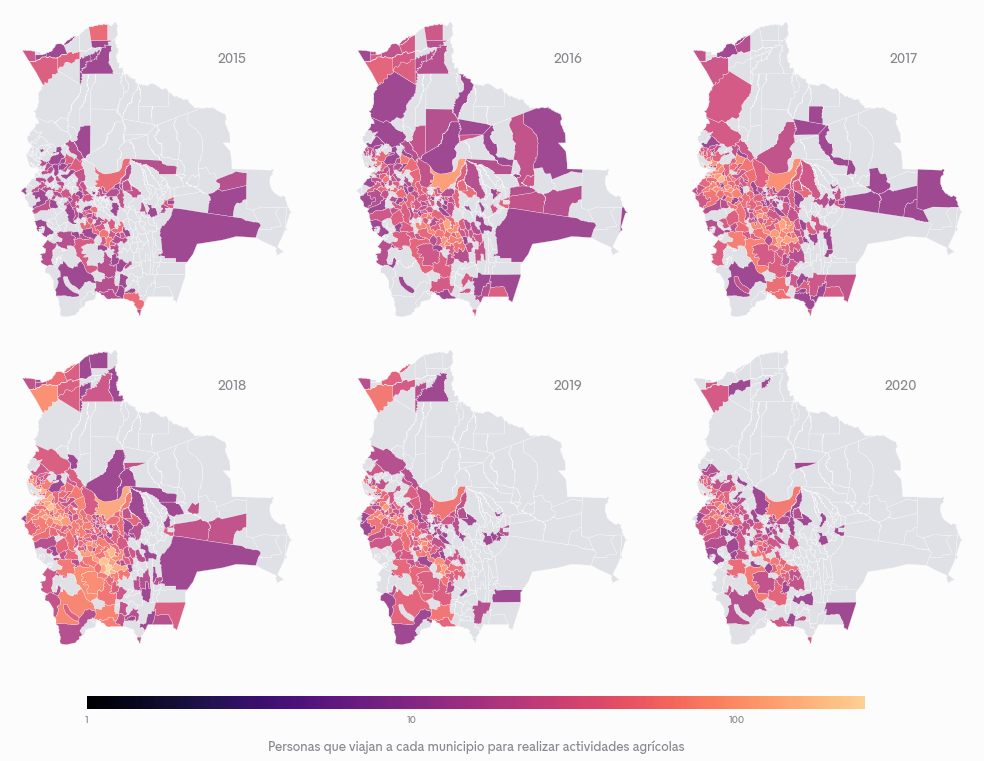

In [341]:
def plot_maps():
    
    lincolor = '#88888f'
    background = '#fcfcfc'
    map_background = '#dfe1e6'
    dfi = df[df.actividad_distante == 'agricultura, ganadería, caza , pesca y silvicultura'].groupby(['año', 'municipio_distante']).size().reset_index(name='count')
    dfi['geometry'] = dfi.municipio_distante.astype(int).map(mapa.to_dict())
    dfi = gpd.GeoDataFrame(dfi, geometry=dfi.geometry)
    
    bins = np.logspace(np.log10(.1), np.log10(dfi['count'].max()), 10)
    colormap=colors.ListedColormap(cm.get_cmap('magma')(np.linspace(.0,.9,250)))
    
    f, axs = plt.subplots(2,3,figsize=(18,12))
    f.set_facecolor(background)
    plt.subplots_adjust(hspace=0.01, wspace=0.005)
    axs = axs.flatten()
    for ax, year in zip(axs, range(2015, 2021)):
        
        lagos.plot(ax=ax, color=map_background, edgecolor=background, linewidth=.3)
        mapa[~mapa.index.isin(dfi[dfi.año == year].municipio_distante)].plot(ax=ax, color=map_background, edgecolor=background, linewidth=.3)
        dfi[dfi.año == year].plot(ax=ax, column='count', cmap=colormap, norm=colors.LogNorm(vmin=0.01, vmax=bins[-1]), edgecolor=background, linewidth=.3, alpha=.85)
        ax.annotate(year,xy=(0.8, 0.86),xycoords="axes fraction",ha="right",va="top",fontsize=13,color=lincolor)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_facecolor(background)
        
    cax = f.add_axes([0.2, 0.06, 0.60, 0.15])
    cax.set_axis_off()
    norm = colors.LogNorm(vmin=1, vmax=bins[-1])
    colorbar = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = f.colorbar(colorbar, ax=cax, orientation="horizontal", pad=.1, aspect=60)
    cbar.set_label(label="Personas que viajan a cada municipio para realizar actividades agrícolas",fontsize=13, color=lincolor,labelpad=15,)
    cbar.ax.tick_params(labelsize=10, labelcolor=lincolor)
    cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    cbar.outline.set_linewidth(0)
        
plot_maps()

La población se dirige particularmente hacia municipios de occidente. Si bien especulo que muchas de estas personas son migrantes que retornan a sus pueblos para trabajar la tierra por un periodo corto de tiempo, otros perfiles y explicaciones son posibles. Una forma de aproximar cuán representativa es la explicación migratoria en la población de un municipio podría ser observando si su tamaño relativo tiene relación con el número de personas que emigraron de él entre 2007 y 2012 según el Censo 2012. Luego de excluir municipios con una tasa de urbanización mayor o igual a 90%, encuentro que estas distribuciones se aproximan para municipios en La Paz, Oruro, Potosí y Cochabamba. Sugiero que la explicación migratoria es más representativa en estos departamentos.

In [109]:
def get_migracion(matriz_filename='data/migracion_2012.csv', expected_type=int):
    """
    Produce una matriz de adyancencias entre municipios donde la 
    población estaba en 2007 y 2012, según el Censo de Población 
    y Vivienda 2012. Cada índice y columna corresponde a un código
    INE y cada valor es una persona.
    """
    
    dfi = pd.read_csv(matriz_filename, index_col=[0])
    d = pd.read_csv('data/cod_ine_censo2012.csv', names=['cod_ine', 'municipio'])
    dfi.index = d.cod_ine
    dfi.columns = d.cod_ine

    for col in dfi.columns:
        dfi[col] = pd.to_numeric(dfi[col].apply(lambda x: x.replace(' ', '').replace('-', ''))).fillna(0).astype(expected_type)
        
    poblacion_2007 = dfi.sum(axis=0)
    np.fill_diagonal(dfi.values, 0)
    emigrantes = migracion.sum(axis=0)
    
    return poblacion_2007, emigrantes

def get_sdsn(normalizado=False, componentes=True):
    
    if normalizado:
        filename = 'data/sdsn_indices.csv'
    else:
        filename = 'data/sdsn.csv'
    
    sdsn = pd.read_csv(filename, index_col='Código')    
    sdsn = sdsn[[col for col in sdsn.columns[2:] if 'Unnamed' not in col]]
    sdsn = sdsn.replace('.', '')
    coltypes = pd.Series({col:sdsn[col].dtype for col in sdsn.columns})
    for col in coltypes[coltypes == object].index.tolist():
        sdsn[col] = pd.to_numeric(sdsn[col].apply(lambda x: x.replace(',', '') if type(x) == str else x))
    if componentes and not normalizado:
        return sdsn[[col for col in sdsn.columns if col in pd.read_csv('data/sdsn_indices.csv').columns.tolist()]]
    else:
        return sdsn

poblacion_2007, emigrantes = get_migracion()
sdsn = get_sdsn(componentes=False)

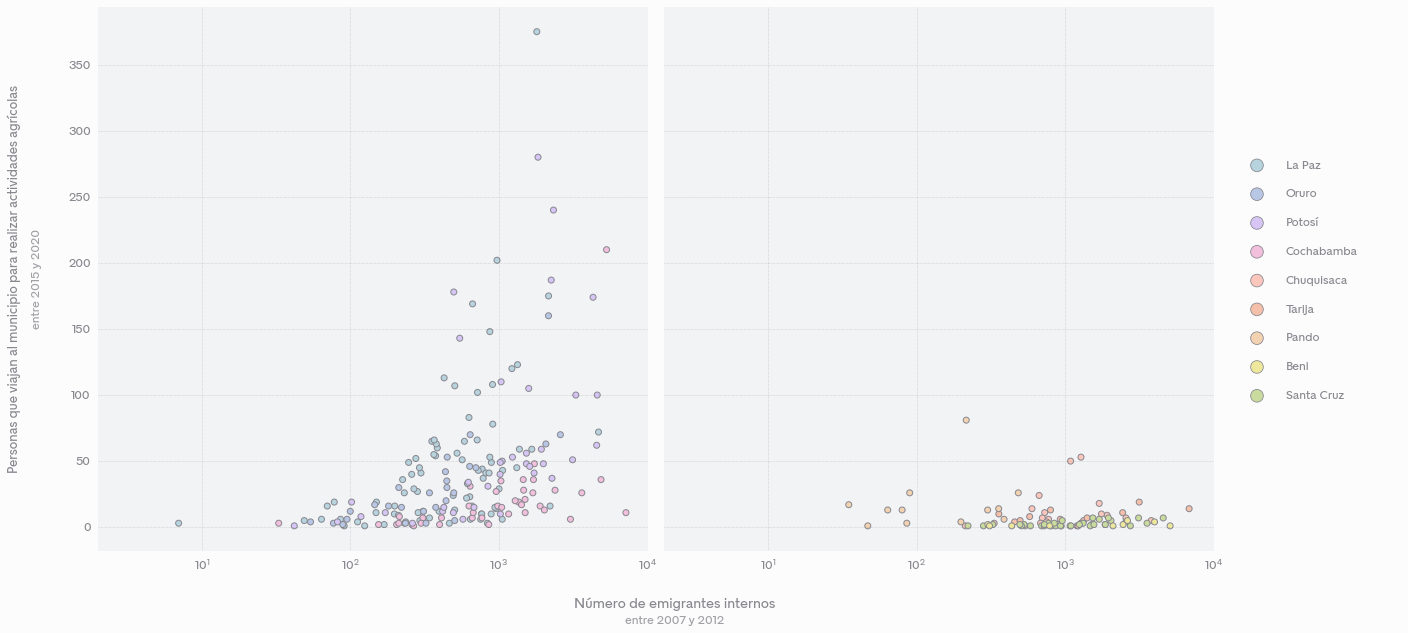

In [222]:
def plot_migracion(departamentos, max_urbanizacion=90):
    
    dep_colores = { 
        'La Paz': '#b6d3de',
        'Oruro': '#b9c7e6',
        'Potosí': '#d7c6f5',
        'Cochabamba': '#f2bfdc',
        'Chuquisaca': '#fbc6bb',
        'Tarija': '#f5c0a9',
        'Pando': '#f2d2b0',
        'Beni': '#eee89d',
        'Santa Cruz': '#c9dc9d'
    }
    lincolor='#88888f'
    background = '#fcfcfc'
    
    dfi = pd.concat([df[df.actividad_distante == 'agricultura, ganadería, caza , pesca y silvicultura'].groupby(['dep_distante', 'municipio_distante']).size().reset_index(name='poblacion').set_index('municipio_distante'), emigrantes], axis=1).dropna()
    dfi.columns = ['departamento', 'trabajadores', 'emigrantes']
    dfi = dfi[dfi.index.isin(sdsn[sdsn['Tasa de urbanización, 2012 (% de población)'] < max_urbanizacion].index)]
    
    f, axs = plt.subplots(1,2,figsize=(20,10), sharey=True)
    plt.subplots_adjust(wspace=.03)
    f.set_facecolor(background)
    
    for ax, deptos in zip(axs, [departamentos, [d for d in dep_colores.keys() if d not in departamentos]]):
    
        dfi2 = dfi[dfi.departamento.isin(deptos)]
        ax.scatter(dfi2.emigrantes, dfi2.trabajadores, color=dfi2.departamento.map(dep_colores), edgecolor=lincolor)
        ax.grid()
        ax.set_xscale('log')
        ax.set_xlim(2,1e4)
        ax.tick_params(labelcolor=lincolor)
        
    
    axs[0].annotate('Número de emigrantes internos', xy=(1.05, -.11), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=lincolor)
    axs[0].annotate('entre 2007 y 2012', xy=(1.05, -.12), xycoords='axes fraction', ha='center', va='top', fontsize=12, color=lincolor, alpha=.8)
    axs[0].annotate('Personas que viajan al municipio para realizar actividades agrícolas', xy=(-.14, .5), xycoords='axes fraction', ha='right', va='center', fontsize=13, color=lincolor, rotation=90)
    axs[0].annotate('entre 2015 y 2020', xy=(-.12, .5), xycoords='axes fraction', ha='left', va='center', fontsize=12, color=lincolor, rotation=90, alpha=.8)

    
    cax = f.add_axes([.91, .3, .12, .4])
    cax.scatter(x=[1] * len(dep_colores.keys()), y=range(len(dep_colores.keys())), color=[dep_colores[k] for k in dep_colores.keys()], s=160, linewidth=.8, edgecolor=lincolor)
    for depto, position in zip(dep_colores.keys(), range(len(dep_colores.keys()))):
        cax.annotate(depto, xy=(1.1, position), xycoords='data', ha='left', va='center', fontsize=12, color=lincolor, alpha=1.)
    cax.set_yticks([])
    cax.set_xticks([])
    cax.set_ylim(9, -1)
    cax.set_xlim(.9, 1.5)
    cax.set_facecolor(background)
        
    
plot_migracion(['La Paz', 'Potosí', 'Oruro', 'Cochabamba'])

Finalmente, es posible explotar esta observación para indagar sobre fenómenos migratorios poco documentados. Por ejemplo, un factor común que predispone a una población a migrar es la expectativa de mejores retornos a su trabajo en la economía de destino. Actividades a las que se dedican migrantes en sus destinos indican dónde existen mayores diferencias salariales entre regiones del país, particularmente entre el campo y la ciudad, sobre las que pueden ejercer cierta capacidad de arbitraje. Esta es la distribución de la población encuestada que viaja para trabajar la tierra, entre las actividades que desempeña en sus economías de residencia habitual y los departamentos donde trabaja la tierra para cada año entre 2015 y 2020:

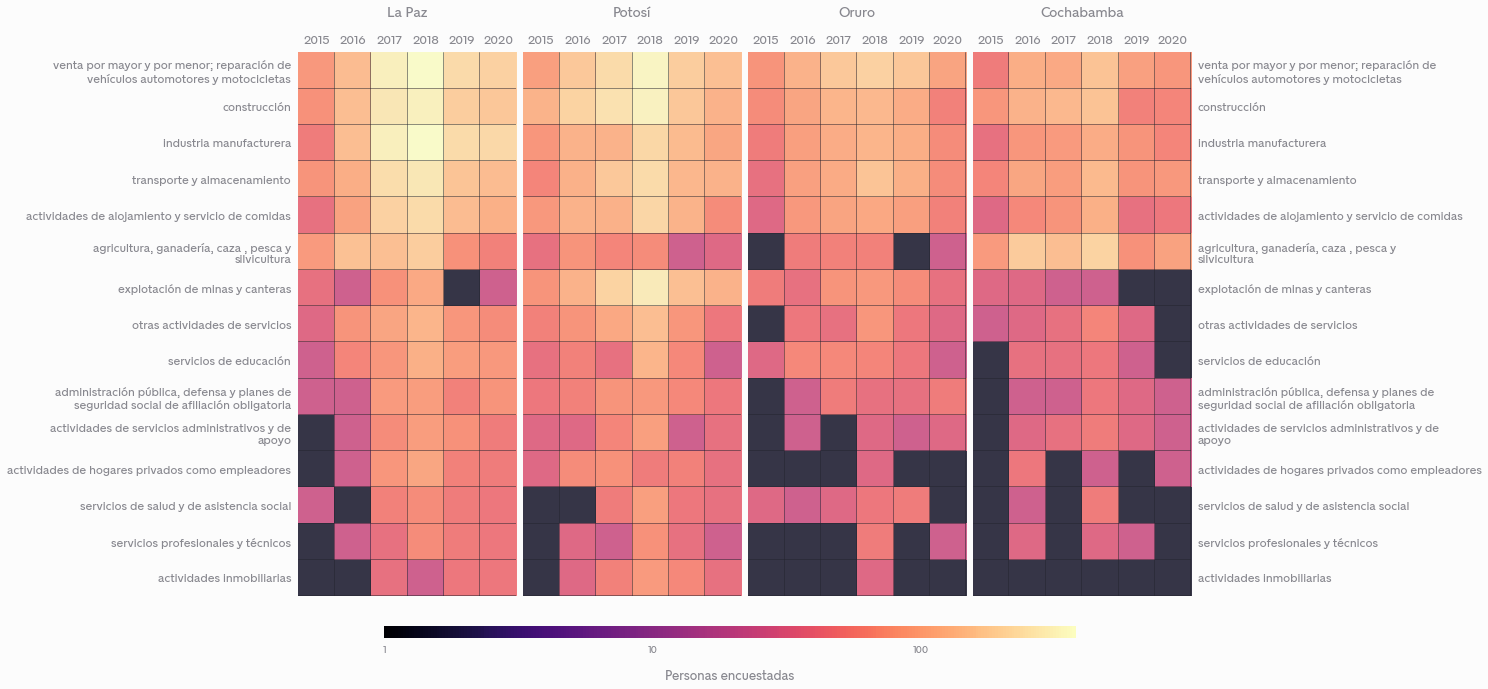

In [342]:
def plot_actividades(departamentos):

    def plot_actividad_depto(ax, dfi, departamento, actividades, colormap, max_value, ylabel):
        
        lincolor='#88888f'
        
        empty = pd.DataFrame(index=actividades, columns=range(2015,2021))
        dfi2 = dfi[(dfi.dep_distante == departamento) & (dfi.actividad_local.isin(actividades))].groupby(['año', 'actividad_local']).size().reset_index(name='poblacion').pivot_table(index='actividad_local', columns='año', values='poblacion')
        dfi2 = pd.concat([dfi2, empty])
        dfi2 = dfi2[~dfi2.index.duplicated(keep='first')].loc[actividades]
        
        ax.imshow(dfi2.fillna(.002), cmap=colormap, aspect='auto', norm=colors.LogNorm(vmin=.001, vmax=max_value), alpha=.8, zorder=1)

        ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi2.index)))))
        ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi2.columns)))))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(dfi2.columns))

        for axis, ticks in zip([ax.yaxis, ax.xaxis], [dfi2.index, dfi2.columns]):
            axis.set_minor_locator(ticker.FixedLocator([i + .485 for i in list(range(len(ticks)))]))

        ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)

        if ylabel is not None:
            ax.yaxis.set_major_formatter(ticker.FixedFormatter(['\n'.join(wrap(i, 50)) for i in dfi2.index]))
            if ylabel == 'left':
                ax.tick_params(labelleft=True)
            elif ylabel == 'right':
                ax.tick_params(labelright=True, labelleft=False)
        else:
            ax.tick_params(labelleft=False)
            
        ax.grid(which='minor', color='#24242e', linestyle='-', linewidth=.5, alpha=1, zorder=2)
        ax.annotate(departamento, xy=(.5, 1.06), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=lincolor)
        
    background = '#fcfcfc'
    colormap=colors.ListedColormap(cm.get_cmap('magma')(np.linspace(.0,1.,250)))
    
    dfi = df[(df.actividad_distante == 'agricultura, ganadería, caza , pesca y silvicultura') & (df.dep_distante.isin(departamentos))]
    actividades = dfi.actividad_local.value_counts().head(15).index
    max_value = dfi.groupby(['año', 'actividad_local', 'dep_local']).size().max()
    
    f, axs = plt.subplots(1,len(departamentos),figsize=(4 * len(departamentos),10))
    f.set_facecolor(background)
    plt.subplots_adjust(wspace=.03)
    labels = ['left'] + [None] * (len(departamentos) - 2) + ['right']
    for ax, dep, ylabel in zip(axs, departamentos, labels):
        plot_actividad_depto(ax, dfi, dep, actividades, colormap, max_value=max_value, ylabel=ylabel)
        
    cax = f.add_axes([0.2, 0.06, 0.60, 0.15])
    cax.set_axis_off()
    norm = colors.LogNorm(vmin=1, vmax=max_value)
    colorbar = plt.cm.ScalarMappable(norm=norm, cmap=colormap)
    cbar = f.colorbar(colorbar, ax=cax, orientation="horizontal", pad=.1, aspect=60)
    cbar.set_label(label="Personas encuestadas",fontsize=13, color=lincolor,labelpad=15,)
    cbar.ax.tick_params(labelsize=10, labelcolor=lincolor)
    cbar.ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    cbar.outline.set_linewidth(0)
    
plot_actividades(['La Paz', 'Potosí', 'Oruro', 'Cochabamba'])